In [157]:
!pip install pyjanitor

In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import janitor

In [159]:
df = pd.read_csv('dataset.csv')
df = janitor.clean_names(df) # Limpieza de nombres
df.head() # lectura ok

,date,year,locality,estimated_value,sale_price,property,residential,num_rooms,num_bathrooms,carpet_area,property_tax_rate,face
0,2009-01-02,2009,Waterbury,111440.0,185000.0,Single Family,Detached House,3,3,996.0,1.025953,South
1,2009-01-02,2009,NaN,73080.0,152000.0,Single Family,Detached House,3,1,935.0,1.025953,North
2,2009-01-02,2009,Waterbury,50540.0,105000.0,Single Family,Detached House,3,1,951.0,1.025953,East
3,2009-01-02,2009,Norwalk,571060.0,1000000.0,Single Family,Detached House,3,2,NaN,1.025953,South
4,2009-01-02,2009,Bridgeport,4775276.0,272900.0,Single Family,Detached House,3,1,971.0,1.025953,East


In [160]:
df.info() # Se ha de corregir fecha

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               10000 non-null  object 
 1   year               10000 non-null  int64  
 2   locality           8745 non-null   object 
 3   estimated_value    8771 non-null   float64
 4   sale_price         10000 non-null  float64
 5   property           10000 non-null  object 
 6   residential        10000 non-null  object 
 7   num_rooms          10000 non-null  int64  
 8   num_bathrooms      10000 non-null  int64  
 9   carpet_area        8718 non-null   float64
 10  property_tax_rate  10000 non-null  float64
 11  face               10000 non-null  object 
dtypes: float64(4), int64(3), object(5)
memory usage: 937.6+ KB


# Data wrangling

Se han de verificar que datos se hayan imputado y leido correctamente a la par que los NA's sean calibrados correctamente

In [161]:
# Data wrangling
df['date'] = pd.to_datetime(df['date'])
df['date'].head(2)

,date
0,2009-01-02
1,2009-01-02


In [162]:
# conteo NA's: Donde haya NA se ha de revisar al detalle
df.isna().sum()

,0
date,0
year,0
locality,1255
estimated_value,1229
sale_price,0
property,0
residential,0
num_rooms,0
num_bathrooms,0
carpet_area,1282


<Axes: >

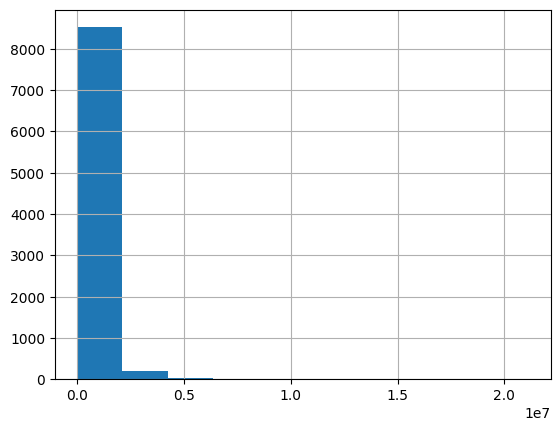

In [163]:
df['estimated_value'].hist()

<Axes: >

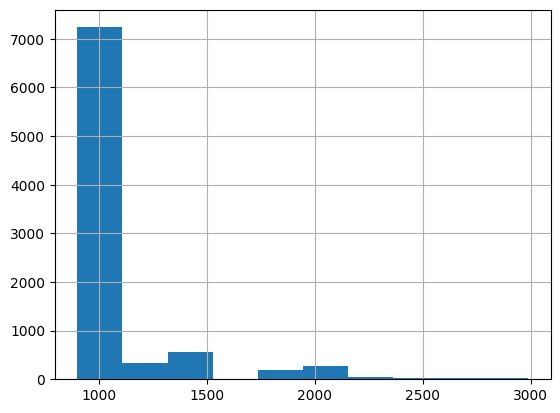

In [164]:
df['carpet_area'].hist()

In [165]:
def reemplazo_mediana(df, columna):
    mediana = df[columna].median()
    df[columna] = df[columna].fillna(mediana)

reemplazo_mediana(df, 'estimated_value')
reemplazo_mediana(df, 'carpet_area')

Existe un inmenso cumulo de datos conglomerados en una cola de informacion. Probablemente se podrian crear categorias o disminuir la escala para poder ver patrones en la informacion. Para realizar este proceso, se aplica escala logaritmica a los datos en el proceso de visualizacion, estandarizar datos o segmentar bajo reglas de negocio.

Los NA's en Locality no se pueden imputar puesto que al ser un inmueble, ubicacion es un factor relevante a tener en cuenta. Para un ejercicio meramente academico se podria considerar imputar estos datos con la moda (valor mas repetido) pero al tratarse de ubicaciones fisicas de inmuebles, no se recomienda imputar un dato tan influyente como la ubicacion de la vivienda. Por estos motivos, se eliminan los registros sin este dato dado que podrian se rinvalidos las inferencias posibles a partir de datos introducidos con tecnicas (incluso avanzadas) de inputacion

In [166]:
df.dropna(subset=['locality'], inplace=True)

In [167]:

# estimate value: Debe ser positivo, mayor a cero
df['estimated_value'].sort_values(ascending=True).head(10)

,estimated_value
750,0.0
1770,0.0
831,0.0
513,3500.0
287,3500.0
414,9100.0
5274,10650.0
234,11830.0
8705,12340.0
8467,13460.0


In [168]:
df = df[df['estimated_value'] > 0]

In [169]:
# New feature

df['spread'] = ((df['sale_price'] - df['estimated_value'])/df['estimated_value']).round(2)
df['spread'].head(2)

,spread
0,0.66
2,1.08


## Spread
Un Spread alto indica ciudades donde los inmuebles se venden por encima de su valor estimado, lo que refleja alta demanda o mercado competitivo.

Para marketing, esto permite enfocar campañas publicitarias en zonas con alta valorización o apetito del comprador.

También sirve como estrategia de fijación de precios y percepción de valor.

# Dataviz

Graficos descriptivo para entender mejor el fenomeno

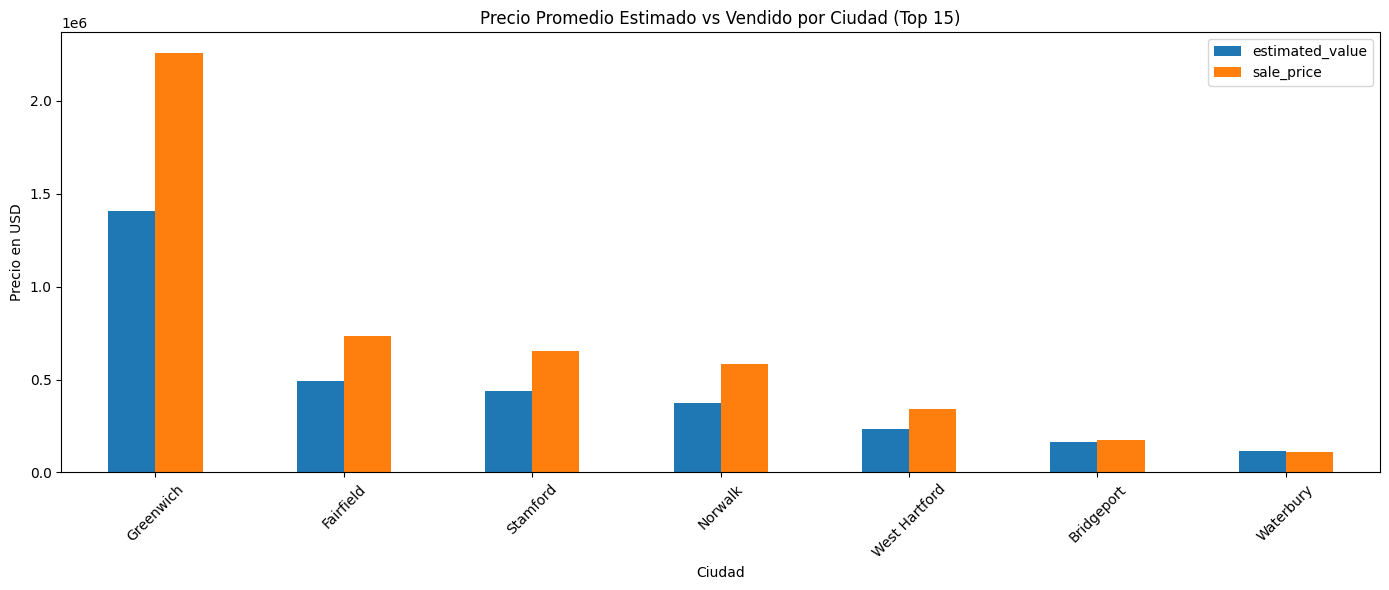

In [170]:
# listado vs vendido promedio por ciudad
grouped = df.groupby('locality')[['estimated_value', 'sale_price']].mean().dropna().sort_values('sale_price', ascending=False).head(15)
grouped.plot(kind='bar', figsize=(14, 6))
plt.title("Precio Promedio Estimado vs Vendido por Ciudad (Top 15)")
plt.ylabel("Precio en USD")
plt.xlabel("Ciudad")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

 * Greenwich destaca como el mercado mas relevante con precios de ventas superiores *(en general)* al precio esperado inicial de venta

  * Waterbury es el menos desviado respecto al valor real, de hecho, casi esta infravaloradomuy ligeramente el precio de venta vs el precio estimado

Esto puede indicar alta demanda o subvaloración en la estimación inicial.

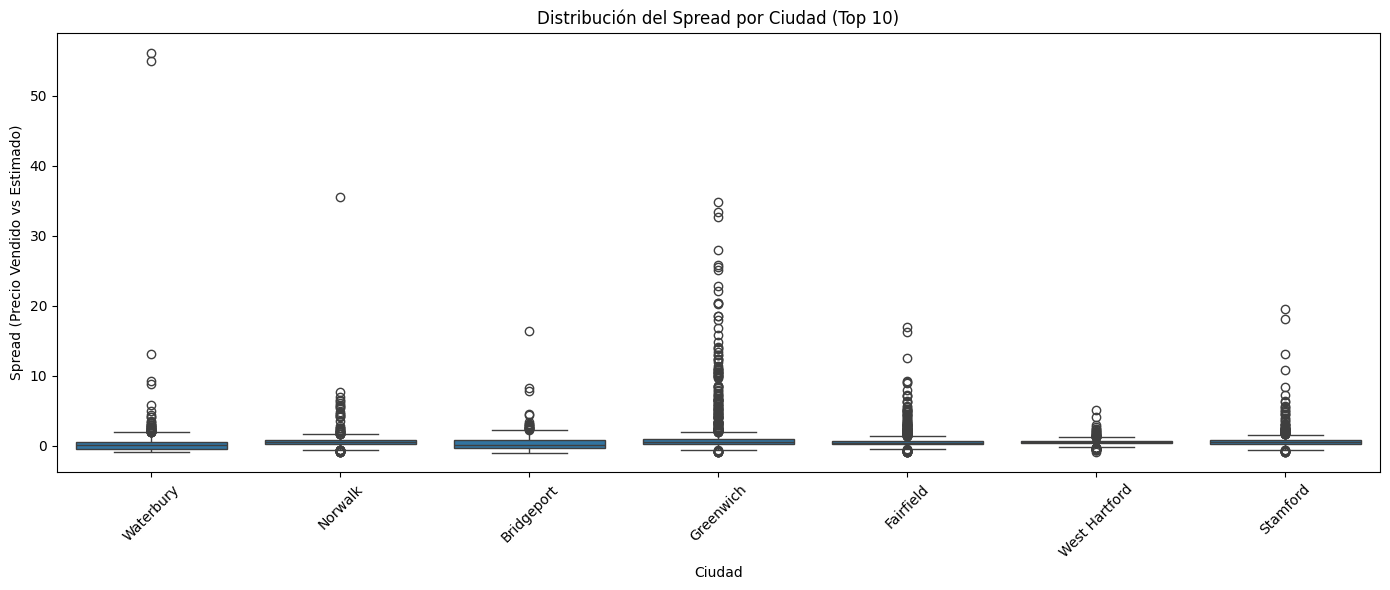

In [171]:
# spread por ciudad (Top 10)
top_cities = df['locality'].value_counts().head(10).index
filtered_df = df[df['locality'].isin(top_cities)]
plt.figure(figsize=(14, 6))
sns.boxplot(x='locality', y='spread', data=filtered_df)
plt.title("Distribución del Spread por Ciudad (Top 10)")
plt.xlabel("Ciudad")
plt.ylabel("Spread (Precio Vendido vs Estimado)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

El Spread revela qué tan por encima o por debajo del valor estimado se vendieron las propiedades.

Ciudades como Bridgeport muestran una gran variabilidad, con muchas propiedades vendidas por debajo del valor estimado (valores negativos).

Otras como Greenwich o Norwalk tienden a venderse por encima del valor estimado.

Esto puede dar señales útiles para marketing y ventas sobre dónde ajustar estrategias de precios o campañas.

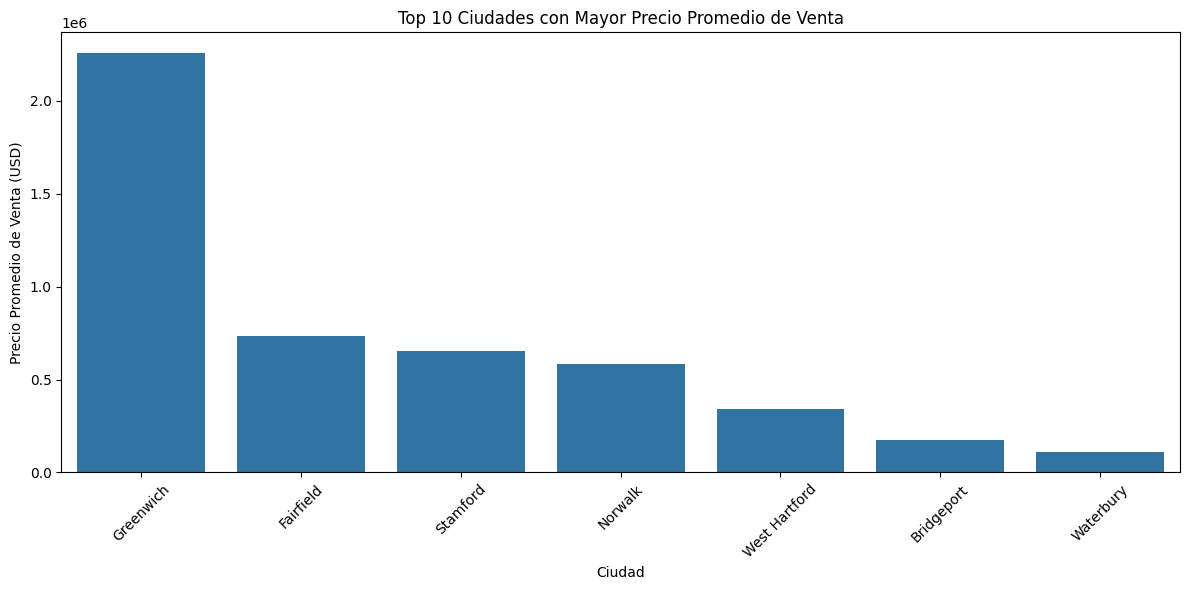

In [172]:
# top 10 ciudades mejores ventas
avg_sale_price = df.groupby('locality')['sale_price'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_sale_price.index, y=avg_sale_price.values)
plt.title("Top 10 Ciudades con Mayor Precio Promedio de Venta")
plt.ylabel("Precio Promedio de Venta (USD)")
plt.xlabel("Ciudad")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Se destaca Greenwich que lidera el precio promedio por encima de los 2 millones de USD. Este precio tan encima del promedio representan ciudades de Lujo o mercados exclusivos. Aca se ve reflejado una estrategia muy marcada, para un mercado de lujo y un mercado estandar.

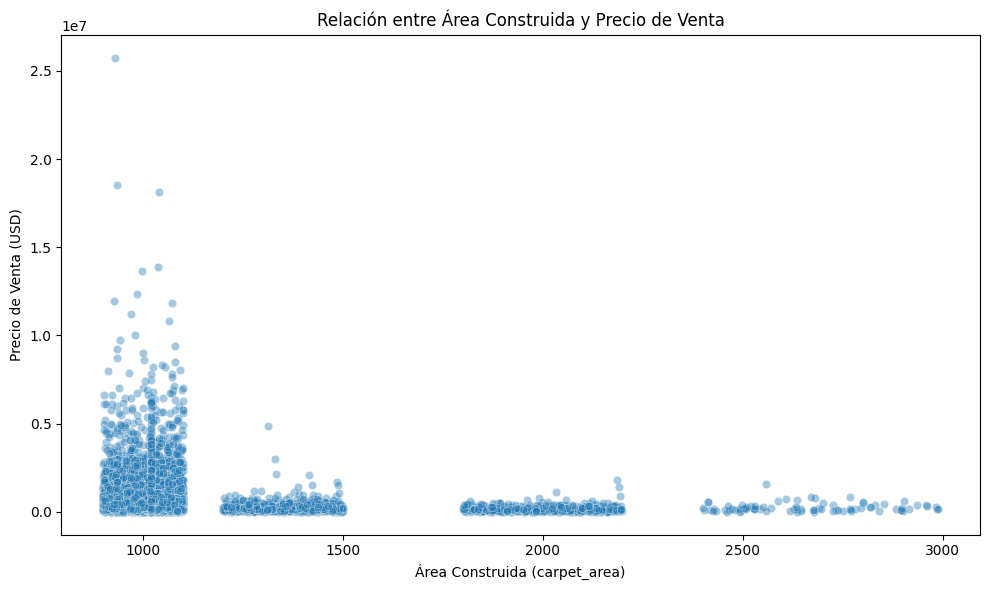

In [173]:
# arrea vs Precio de Venta
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='carpet_area', y='sale_price', alpha=0.4)
plt.title("Relación entre Área Construida y Precio de Venta")
plt.xlabel("Área Construida (carpet_area)")
plt.ylabel("Precio de Venta (USD)")
plt.tight_layout()
plt.show()


Se esperaria una relacion muy marcada entre el area del inmueble vs el precio sin embargo, no existe una relaion clara marcada. Probablemente esto sea cierto a nivel de area, mas no a nivel global. Se propone el siguiente grafico.

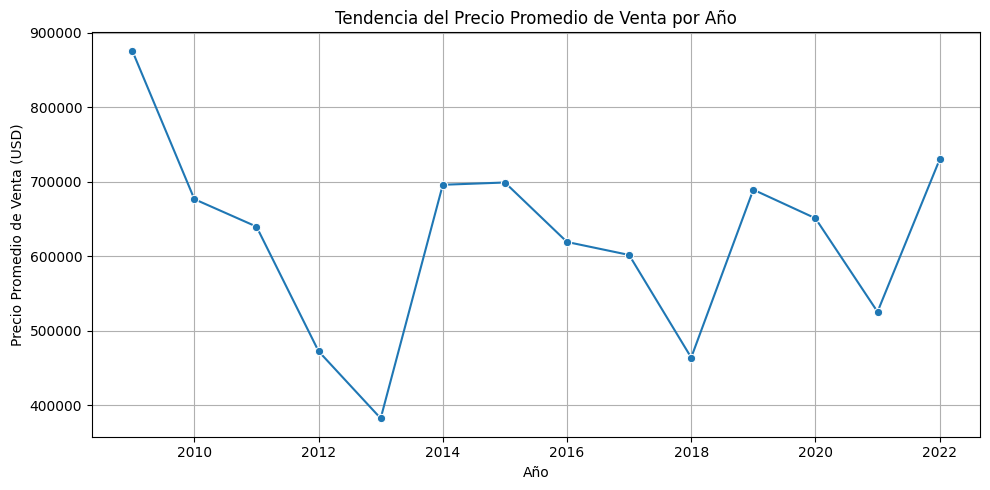

In [174]:
# precio en el tienpo (promedio)
avg_price_by_year = df.groupby('year')['sale_price'].mean()
plt.figure(figsize=(10, 5))
sns.lineplot(x=avg_price_by_year.index, y=avg_price_by_year.values, marker='o')
plt.title("Tendencia del Precio Promedio de Venta por Año")
plt.xlabel("Año")
plt.ylabel("Precio Promedio de Venta (USD)")
plt.grid(True)
plt.tight_layout()
plt.show()


Se observa una caída abrupta entre 2009 y 2011, posiblemente reflejo de la crisis inmobiliaria.

Desde 2012 hay una recuperación progresiva, aunque con cierta oscilación en los últimos años.

Esta tendencia puede ser clave para los equipos de ventas y marketing al planear estrategias de acuerdo con el ciclo del mercado.

Analicemos este grafico pero por las 3 areas top en precio promedio de venta.

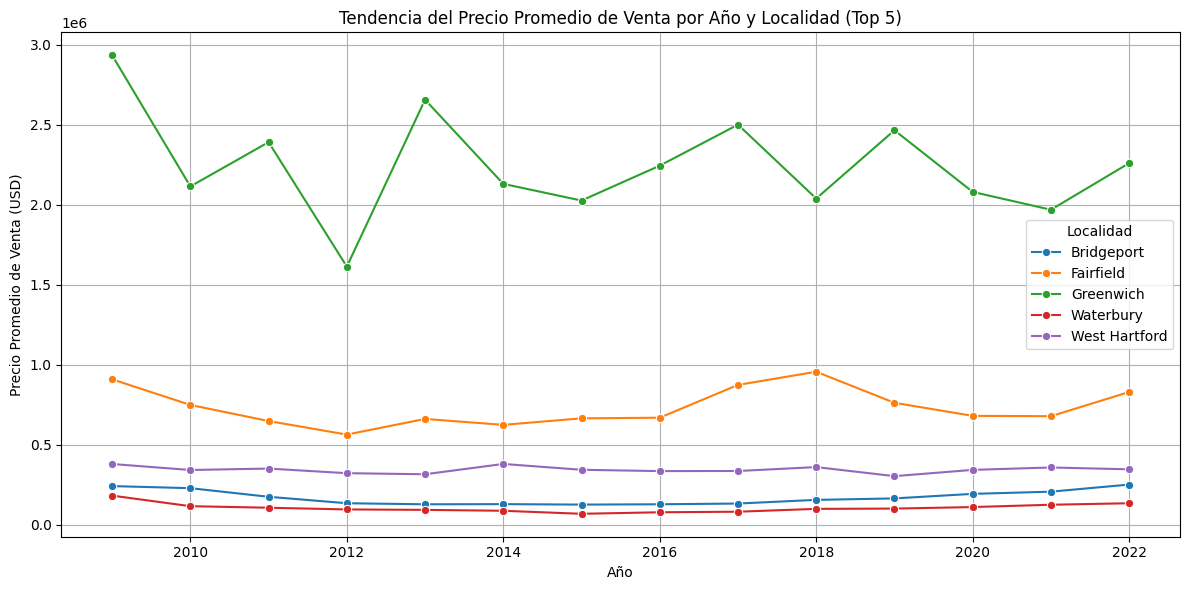

In [175]:

top_localities = df['locality'].value_counts().head(5).index

filtered_df = df[df['locality'].isin(top_localities)]

avg_price_by_year_city = (
    filtered_df.groupby(['year', 'locality'])['sale_price']
    .mean()
    .reset_index()
)

plt.figure(figsize=(12, 6))
sns.lineplot(data=avg_price_by_year_city, x='year', y='sale_price', hue='locality', marker='o')
plt.title("Tendencia del Precio Promedio de Venta por Año y Localidad (Top 5)")
plt.xlabel("Año")
plt.ylabel("Precio Promedio de Venta (USD)")
plt.legend(title='Localidad')
plt.grid(True)
plt.tight_layout()
plt.show()


In [176]:
# Benchmark de Marketing: Spread promedio por ciudad (Top 10 volumen)
top_cities_by_volume = df['locality'].value_counts().head(10).index
marketing_benchmark = df[df['locality'].isin(top_cities_by_volume)].groupby('locality')['spread'].mean().sort_values(ascending=False)
print("Benchmark de Marketing - Spread Promedio por Ciudad:")
print(marketing_benchmark)


Benchmark de Marketing - Spread Promedio por Ciudad:
locality
Greenwich        1.470894
Norwalk          0.630468
Stamford         0.626160
Fairfield        0.622555
West Hartford    0.488137
Bridgeport       0.248766
Waterbury        0.202208
Name: spread, dtype: float64


Greenwich destaca de forma contundente: las propiedades se venden en promedio a más del doble de su valor estimado. Esto puede deberse a una combinación de fuerte demanda, valorización del entorno y percepción de exclusividad.

 * Estrategia sugerida: campañas de marketing orientadas a inversionistas premium o compradores internacionales.

Norwalk, Stamford y Fairfield también presentan spreads elevados (~62–63%), lo que indica mercados con buena dinámica de valorización.

 * Estrategia: resaltar el retorno potencial y crecimiento en zonas con alta plusvalía.

Bridgeport y Waterbury tienen spreads menores, pero positivos, lo que sugiere mercados más estables o conservadores.

 * Estrategia: destacar accesibilidad o oportunidades de revalorización a largo plazo.



In [177]:
# Benchmark de Ventas: Precio promedio por pie cuadrado
df['price_per_sqft'] = (df['sale_price'] / df['carpet_area']).round(2)
sales_benchmark = df[df['carpet_area'].notnull()].groupby('locality')['price_per_sqft'].mean().sort_values(ascending=False).head(10)
print("\nBenchmark de Ventas - Precio Promedio por pie cuadrado:")
print(sales_benchmark)


Benchmark de Ventas - Precio Promedio por pie cuadrado:
locality
Greenwich        2238.916294
Fairfield         731.017777
Stamford          634.117739
Norwalk           572.750984
West Hartford     338.968959
Bridgeport        151.971038
Waterbury          97.702527
Name: price_per_sqft, dtype: float64


El precio promedio por pie cuadrado (price_per_sqft) es un indicador fundamental para los equipos de ventas, ya que permite:

 1. Comparar precios relativos entre ciudades.

 2. Establecer rangos de referencia al listar inmuebles.

 3. Identificar mercados de alto valor por unidad de área.

 Greenwich domina como el mercado más exclusivo, con un precio por pie² que triplica al segundo lugar.
 * implica una percepción premium del entorno, infraestructura y demanda sostenida de alto poder adquisitivo.

Fairfield, Stamford y Norwalk conforman un segundo grupo de mercados sólidos, con precios entre 570 y 730 USD por pie².
 * Ideal para estrategias de ventas enfocadas en retorno de inversión, valorización y calidad de vida.

Bridgeport y Waterbury, con valores por debajo de 160 USD/pie², representan mercados más asequibles.
 * `Oportunidad para captar compradores primerizos, inversionistas con menor capital o proyectos de renovación.

# Modelado

Se ejecuta un analisis de clusters para identificar grupos poblacionales. Se esperan divisiones significativas y ojo, primero se vana a escalar los datos. Let's go baby!

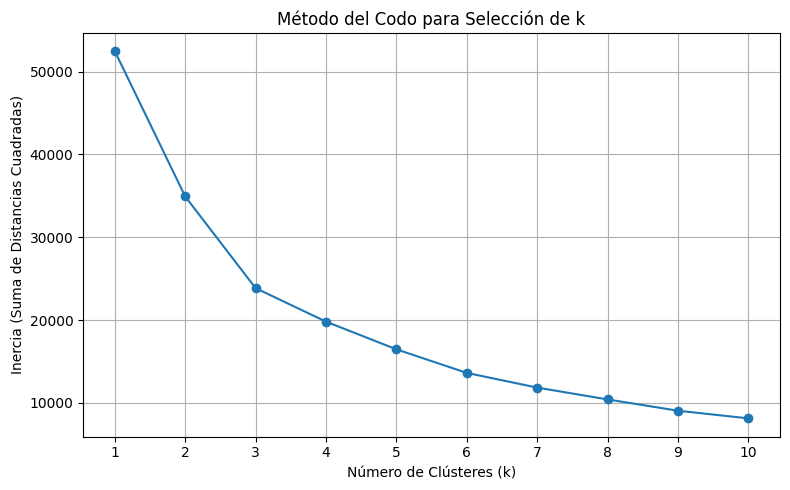

In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Features que usare, por ahora numericas only
features = ['sale_price', 'carpet_area', 'price_per_sqft', 'spread', 'num_rooms', 'num_bathrooms']
df_cluster = df[features].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

#elbou chart
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Número de Clústeres (k)')
plt.ylabel('Inercia (Suma de Distancias Cuadradas)')
plt.title('Método del Codo para Selección de k')
plt.xticks(k_range)
plt.grid(True)
plt.tight_layout()
plt.show()



Hasta este punto se podria considerar que el algoritmo podria tener 4 posibles grupos dado el % de var explciada por el modelo

In [189]:
explained_variance = pca.explained_variance_ratio_
explained_variance_cum = np.cumsum(explained_variance)

# Mostrar tabla con varianza explicada individual y acumulada
pca_summary = pd.DataFrame({
    'Componente': [f'PC{i+1}' for i in range(len(explained_variance))],
    'Varianza Explicada': np.round(explained_variance, 4),
    'Varianza Acumulada': np.round(explained_variance_cum, 4)
})

print(pca_summary)


  Componente  Varianza Explicada  Varianza Acumulada
0        PC1              0.4581              0.4581
1        PC2              0.3242              0.7823
2        PC3              0.1413              0.9235
3        PC4              0.0620              0.9855
4        PC5              0.0141              0.9996
5        PC6              0.0004              1.0000


Y aca vemos que hasta 3 componentes podriamos reducir la dimensionaldiad del algoritmo. Esto dado que PCA permite seleccioanar la proporcio. de varianza con el cambio de ejes.

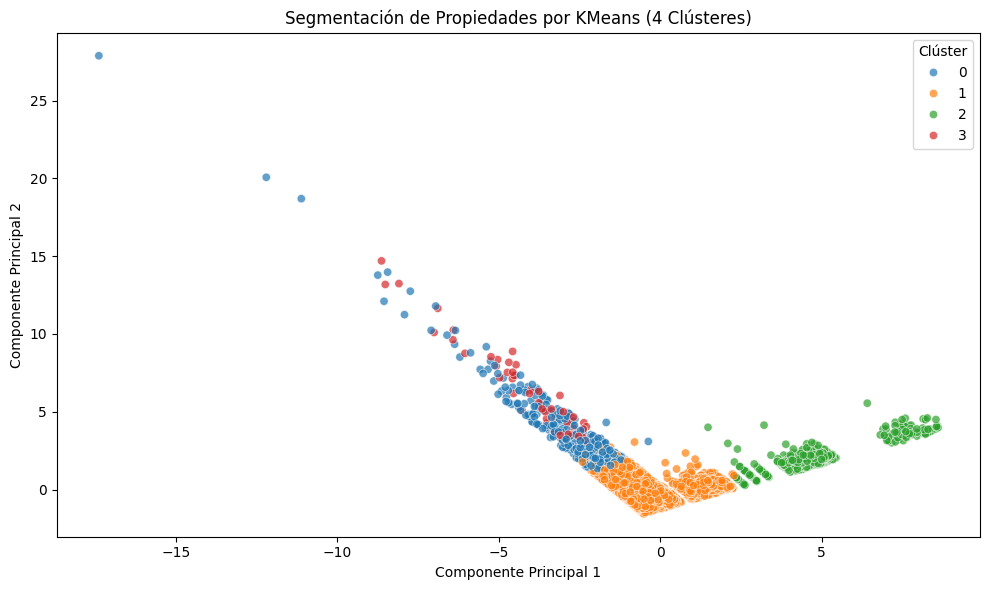

In [190]:

pca_final = PCA(n_components=3)
X_pca3 = pca_final.fit_transform(X_scaled)

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_pca3)
df_cluster['cluster'] = clusters

df_cluster['pca1'] = X_pca3[:, 0]
df_cluster['pca2'] = X_pca3[:, 1]
df_cluster['pca3'] = X_pca3[:, 2]


plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cluster, x='pca1', y='pca2', hue='cluster', palette='tab10', alpha=0.7)
plt.title("Segmentación de Propiedades por KMeans (4 Clústeres)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Clúster")
plt.tight_layout()
plt.show()


In [191]:
# Grafica en 3 para mas placer
import plotly.express as px

fig = px.scatter_3d(
    df_cluster,
    x='pca1', y='pca2', z='pca3',
    color='cluster',
    opacity=0.7,
    title="Clústeres en espacio PCA (3D)",
    labels={'pca1': 'PC1', 'pca2': 'PC2', 'pca3': 'PC3'},
    color_continuous_scale='Viridis'
)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=30))
fig.show()


In [193]:
score_pca3 = silhouette_score(X_pca3, df_cluster['cluster'])
print(f"Silhouette Score en PCA (3 componentes): {score_pca3:.4f}")

# pa ver si PCA sirvio pa algo
score_original = silhouette_score(X_scaled, df_cluster['cluster'])
print(f"🔍 Silhouette Score en espacio original: {score_original:.4f}")

✅ Silhouette Score en PCA (3 componentes): 0.7196
🔍 Silhouette Score en espacio original: 0.6720


WAOS, SI SIRVIO

In [187]:
# Asegúrate de que df_cluster y df tengan el mismo orden de índices
df['cluster'] = df_cluster['cluster'].values
# Por ejemplo, agrupar por prom de precio y metro cuadrado
df.groupby([ 'cluster']).agg({
    'sale_price': ['mean'],
    'price_per_sqft': 'mean'
}).round(1)


,sale_price,price_per_sqft
,mean,mean
cluster,,
0,4212991.8,4196.8
1,463355.8,456.9
2,195454.9,106.3
3,3688544.3,3635.3


dado que las metricas de coef. de silueta son buenas, el ejercicio de modelado  permite confiar en estos resultados (coef. de Silhoute cercano a 1) y dado esto, podriamos identificar entonces agrupaciones en los datos para crear una estrategia.

| Cluster | Precio promedio (`sale_price`) | Precio por m² (`price_per_sqft`) | Interpretación                                                                                |
| ------- | ------------------------------ | -------------------------------- | --------------------------------------------------------------------------------------------- |
| **0**   | \$4.213.992                    | \$4.196,8                        |  Segmento alto: propiedades costosas y de alto valor por m² (ej: **Greenwich**)             |
| **1**   | \$463.356                      | \$456,9                          |  Segmento medio-bajo: propiedades más accesibles, pero aún con m² razonable                 |
| **2**   | \$195.455                      | \$106,3                          |  Segmento bajo: propiedades económicas y con precio por m² muy reducido (ej: **Waterbury**) |
| **3**   | \$3.688.544                    | \$3.635,3                        |  Segmento alto, quizás un poco inferior al clúster 0                                        |


In [194]:
df.groupby(['locality', 'cluster']).size().unstack(fill_value=0)


cluster,0,1,2,3
locality,,,,
Bridgeport,0,1424,261,1
Fairfield,23,1297,2,5
Greenwich,327,690,11,46
Norwalk,16,994,15,1
Stamford,10,978,34,4
Waterbury,0,1248,257,3
West Hartford,1,1082,12,0


El análisis de la distribución de los clústeres por localidad muestra una segmentación clara y coherente del mercado inmobiliario. El clúster 0, compuesto por propiedades de alto precio y valor por metro cuadrado, se concentra principalmente en Greenwich y, en menor medida, en Fairfield, lo que indica un mercado de alta gama. El clúster 1 es el más representativo y se encuentra en todas las ciudades analizadas, reflejando un segmento de clase media o media-alta con amplia cobertura geográfica. El clúster 2 agrupa propiedades de bajo valor, con alta concentración en Bridgeport y Waterbury, lo que sugiere un perfil económico más bajo en estas zonas. Por su parte, el clúster 3 también corresponde a propiedades de alto valor, aunque con una distribución más limitada, predominando en Greenwich y Fairfield, posiblemente asociado a tipologías específicas dentro del segmento de lujo. Esta segmentación permite identificar patrones territoriales relevantes y perfiles de mercado diferenciados, útiles para la toma de decisiones estratégicas.

# Cluster Dataviz

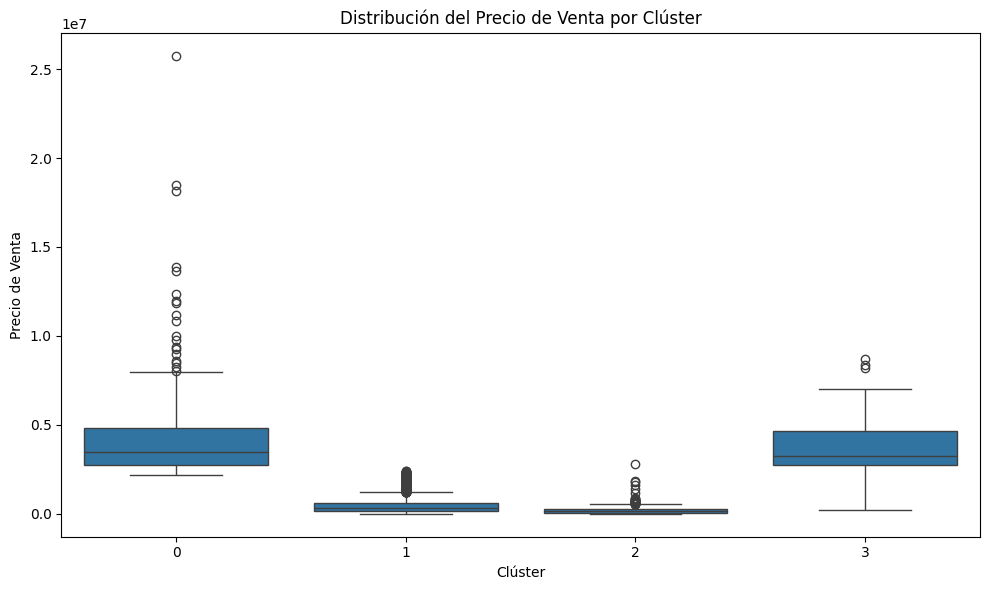

In [195]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='sale_price', data=df)
plt.title('Distribución del Precio de Venta por Clúster')
plt.ylabel('Precio de Venta')
plt.xlabel('Clúster')
plt.tight_layout()
plt.show()

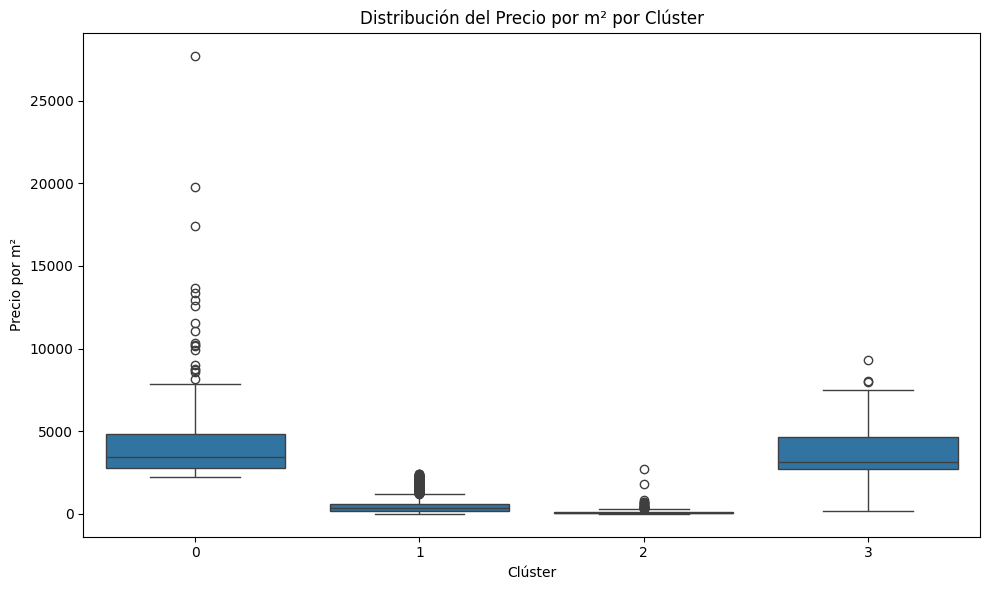

In [196]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='price_per_sqft', data=df)
plt.title('Distribución del Precio por m² por Clúster')
plt.ylabel('Precio por m²')
plt.xlabel('Clúster')
plt.tight_layout()
plt.show()


/tmp/ipython-input-2901124471.py:2: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




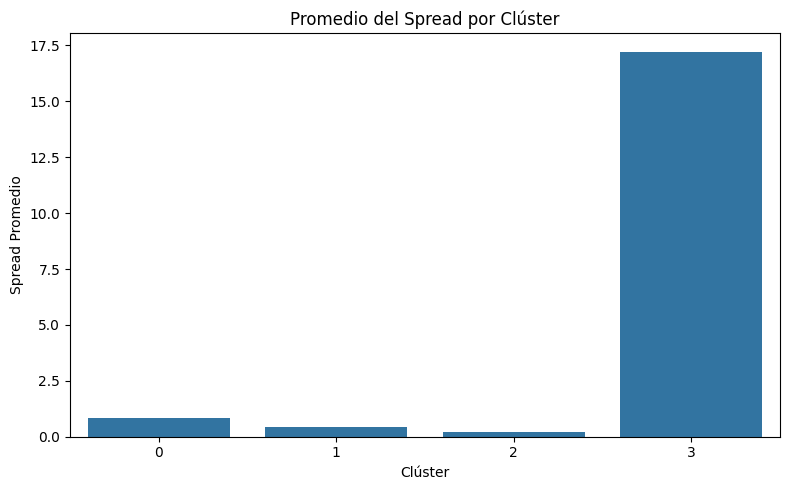

In [198]:
plt.figure(figsize=(8, 5))
sns.barplot(x='cluster', y='spread', data=df, estimator='mean', ci=None)
plt.title('Promedio del Spread por Clúster')
plt.ylabel('Spread Promedio')
plt.xlabel('Clúster')
plt.tight_layout()
plt.show()


/tmp/ipython-input-2337376564.py:2: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




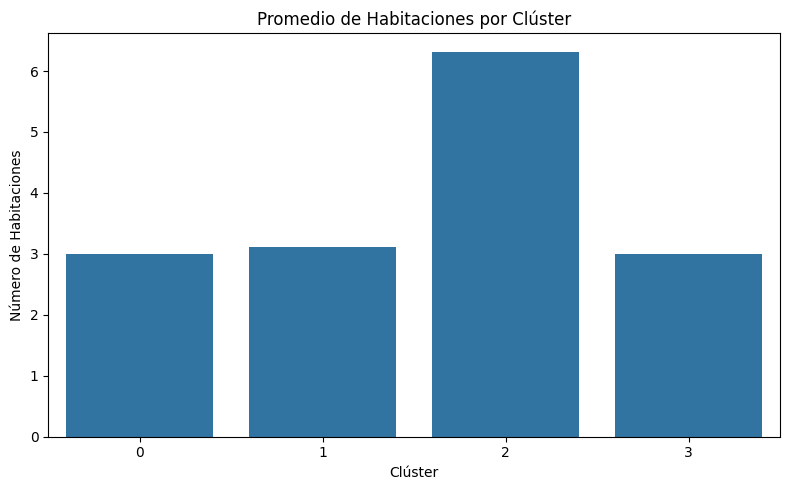

In [199]:
plt.figure(figsize=(8, 5))
sns.barplot(x='cluster', y='num_rooms', data=df, estimator='mean', ci=None)
plt.title('Promedio de Habitaciones por Clúster')
plt.ylabel('Número de Habitaciones')
plt.xlabel('Clúster')
plt.tight_layout()
plt.show()


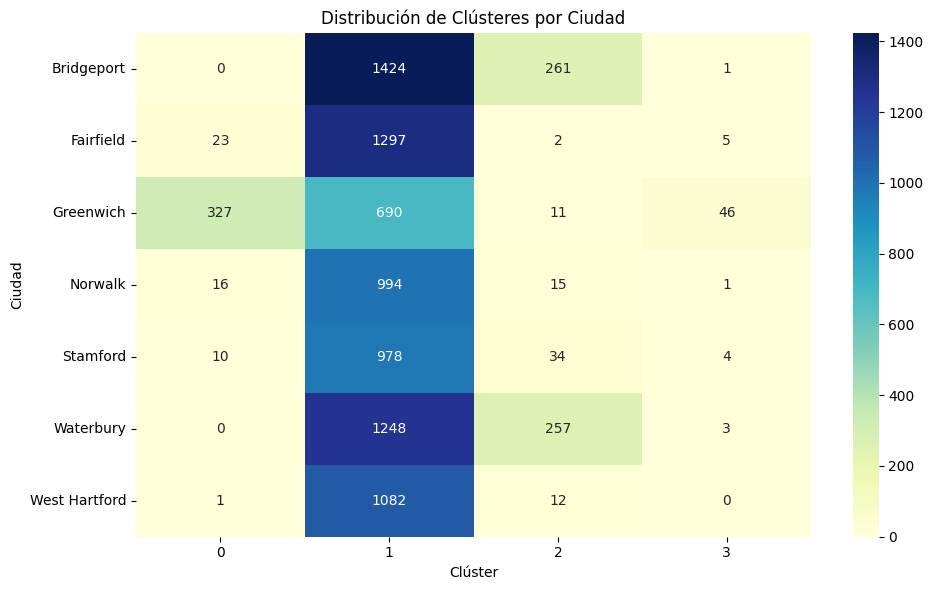

In [200]:
cluster_loc = df.groupby(['locality', 'cluster']).size().unstack(fill_value=0)

plt.figure(figsize=(10, 6))
sns.heatmap(cluster_loc, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Distribución de Clústeres por Ciudad')
plt.ylabel('Ciudad')
plt.xlabel('Clúster')
plt.tight_layout()
plt.show()


In [ ]:
import joblib

# Exportar el modelo PCA (con 3 componentes)
joblib.dump(pca_final, 'modelo_pca_3componentes.pkl')

# Exportar el DataFrame original con los clusters
df.to_csv('dataset_con_clusters.csv', index=False)